In [1]:
import os
import pickle

import matplotlib.pyplot as plt

from multitask.representations import calculate_rsa_diagonal

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#a1c9f4ff', '#ffaaa8ff', '#8ce4a0ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_sm_individual = os.path.join('pickle', f'rdm_individual.pickle')
path_sm_parallel = os.path.join('pickle', f'rdm_parallel.pickle')
path_sm_all = os.path.join('pickle', f'rdm_task_switching.pickle')

In [4]:
path_figure = os.path.join('svg', 'figure02b_rsa_models.svg')

In [5]:
with open(path_sm_individual, 'rb') as handle:
    list_sm_individual = pickle.load(handle)

with open(path_sm_parallel, 'rb') as handle:
    list_sm_parallel = pickle.load(handle)

with open(path_sm_all, 'rb') as handle:
    list_sm_task_switching = pickle.load(handle)

In [6]:
rsa_individual_parallel = calculate_rsa_diagonal(list_sm_individual,
                                                 list_sm_parallel,
                                                 num_inputs=10)

mean_rsa_individual_parallel = rsa_individual_parallel.mean(axis=0)
std_rsa_individual_parallel = rsa_individual_parallel.std(axis=0)

rsa_individual_task_switching = calculate_rsa_diagonal(list_sm_individual,
                                                       list_sm_task_switching,
                                                       num_inputs=10)

mean_rsa_individual_task_switching = rsa_individual_task_switching.mean(axis=0)
std_rsa_individual_task_switching = rsa_individual_task_switching.std(axis=0)

rsa_parallel_task_switching = calculate_rsa_diagonal(list_sm_parallel,
                                                     list_sm_task_switching,
                                                     num_inputs=10)

mean_rsa_parallel_task_switching = rsa_parallel_task_switching.mean(axis=0)
std_rsa_parallel_task_switching = rsa_parallel_task_switching.std(axis=0)

In [7]:
num_layers = len(list_sm_individual[0])

assert num_layers == len(list_sm_parallel[0])
assert num_layers == len(list_sm_task_switching[0])

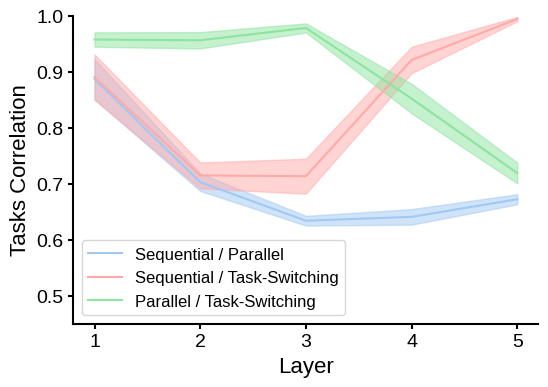

In [8]:
layers = range(1, num_layers + 1)
fig = plt.figure(figsize=(6, 4))

plt.plot(layers, mean_rsa_individual_parallel, color=palette[0])
plt.plot(layers, mean_rsa_individual_task_switching, color=palette[1])
plt.plot(layers, mean_rsa_parallel_task_switching, color=palette[2])

plt.fill_between(layers,
                 mean_rsa_individual_parallel-std_rsa_individual_parallel,
                 mean_rsa_individual_parallel+std_rsa_individual_parallel,
                 alpha=0.5,
                 color=palette[0])

plt.fill_between(layers,
                 mean_rsa_individual_task_switching-std_rsa_individual_task_switching,
                 mean_rsa_individual_task_switching+std_rsa_individual_task_switching,
                 alpha=0.5,
                 color=palette[1])


plt.fill_between(layers,
                 mean_rsa_parallel_task_switching-std_rsa_parallel_task_switching,
                 mean_rsa_parallel_task_switching+std_rsa_parallel_task_switching,
                 alpha=0.5,
                 color=palette[2])

plt.xlabel('Layer')
plt.xticks(range(1, num_layers+1))
plt.ylim(0.45, 1)
plt.legend(['Sequential / Parallel', 'Sequential / Task-Switching', 'Parallel / Task-Switching'], prop={'size':12})
plt.ylabel('Tasks Correlation')

fig.savefig(path_figure)
plt.show()